# Libraries and importing data

In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import re

### Visualization packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

### Scikit learn for logistics regression

In [3]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, RFE, RFECV
from sklearn.feature_selection import RFE

In [4]:
import info5604_utils as util

### Importing the data. Dataset is multileveled so it needs to be imported this way

Display more columns

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv("../clean_data/data.csv", header=[0,1],index_col=[0])
df = df[df['golddiff','min_20'].notna()] #get rid of NA
print(df.shape)
df.head()

(7578, 99)


Info                       \
                                             Address League  Year  Season   
0  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
1  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
2  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
3  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
4  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   

                                Blue                                 \
  GameType gamelength Winner TeamTag      Top  TopChamp      Jungle   
0   Season         40   Blue     TSM    Dyrus    Irelia    Santorin   
1   Season         38    Red     CST     Cris      Gnar     Impaler   
2   Season         40   Blue     WFX  Flaresz  Renekton  ShorterACE   
3   Season         41    Red     TIP     Rhux    Irelia        Rush   
4   Season         35   Blue     CLG    Benny      Gnar     Xmithie   

                                                                        \
  JungleChamp       Middle MiddleChamp         ADC  ADCChamp   Support   
0      RekSai     Bjergsen        Ahri  WildTurtle      Jinx   Lustboy   
1      Rengar        Jesiz        Ahri        Mash   Caitlyn     Sheep   
2      Rengar     Pobelter        Fizz       Altec     Sivir     Gleeb   
3    JarvanIV  XiaoWeiXiao     Leblanc      Apollo     Sivir    Adrian   
4    JarvanIV         Link   Lissandra  Doublelift  Tristana  aphromoo   

                   Red                                                  \
  SupportChamp TeamTag          Top TopChamp        Jungle JungleChamp   
0        Janna      C9        Balls     Gnar        Meteos       Elise   
1        Leona     DIG        Gamsu   Irelia       Crumbzz    JarvanIV   
2        Annie      GV     Hauntzer     Sion  Saintvicious      LeeSin   
3       Thresh      TL         Quas     Gnar    IWDominate        Nunu   
4        Janna      T8  CaliTrlolz8     Sion     Porpoise8      RekSai   

                                                                          \
     Middle MiddleChamp           ADC ADCChamp      Support SupportChamp   
0       Hai        Fizz        Sneaky    Sivir  LemonNation       Thresh   
1  Shiphtur        Azir        CoreJJ    Corki      KiWiKiD        Annie   
2     Keane        Azir           Cop    Corki   BunnyFuFuu        Janna   
3     Fenix        Lulu         KEITH   KogMaw      Xpecial        Janna   
4  Slooshi8        Lulu  Maplestreet8    Corki        Dodo8        Annie   

       Blue                                         Red                    \
      ban_1      ban_2      ban_3 ban_4 ban_5     ban_1    ban_2    ban_3   
0    Rumble   Kassadin  Lissandra   NaN   NaN  Tristana  Leblanc  Nidalee   
1  Kassadin      Sivir  Lissandra   NaN   NaN    RekSai    Janna  Leblanc   
2  JarvanIV  Lissandra   Kassadin   NaN   NaN   Leblanc      Zed   RekSai   
3     Annie  Lissandra   Kassadin   NaN   NaN    RekSai   Rumble   LeeSin   
4    Irelia   Pantheon   Kassadin   NaN   NaN    Rumble    Sivir   Rengar   

              golddiff                       goldblue                         \
  ban_4 ban_5    min_5 min_10 min_15  min_20    min_5 min_10 min_15   min_20   
0   NaN   NaN     -268   -625   -790  1422.0     5068  11361  18324  29519.0   
1   NaN   NaN      147   -242   1394  1105.0     5511  11419  19698  27282.0   
2   NaN   NaN       34    913   2922  5293.0     4933  12374  21237  31317.0   
3   NaN   NaN      228     16   -335   768.0     5398  12033  19332  25772.0   
4   NaN   NaN      113    205   -574   478.0     5404  11943  19426  27472.0   

  goldred                        goldblueTop                        \
    min_5 min_10 min_15   min_20       min_5 min_10 min_15  min_20   
0    5336  11986  19114  28097.0         893   2051   3630  6008.0   
1    5364  11661  18304  26177.0        1127   2406   4594  6217.0   
2    4899  11461  18315  26024.0         828   2419   4187

In [7]:
df = df.fillna('No Ban') # Indicate where there was no ban

In [8]:
y = df['Info','Winner']
X = df.drop(['Winner','Address'],level = 1,axis=1)

Creating the Training, Validation, and Testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20220905, stratify=y)

#### To call out a column:

Ex: Grabbing the results from the imported data

DataFrameName[ LevelName, ColumnName] = df[ 'Info', 'Winner']

#### To use in the models it's similar to calling out:

(LevelName, ColumnName) = ('Info', 'League')

# Logistics Regression

Creating the model and the pipeline to search for the optimal parameters

In [10]:
LR_model = LogisticRegression(penalty='none', max_iter=1000, random_state=14, tol=1.0e-08, solver='liblinear')

In [11]:
CATEGORICAL_VARS=[('Info','League'), ('Info','Year'), ('Info','Season'), ('Info','GameType'), 
                  ('Blue', 'Top'), ('Blue','TopChamp'), ('Blue','Jungle'), ('Blue','JungleChamp'),
                  ('Blue','Middle'), ('Blue','MiddleChamp'), ('Blue', 'ADC'), ('Blue','ADCChamp'),
                  ('Blue', 'Support'), ('Blue', 'SupportChamp'), ('Blue', 'TeamTag'),
                  ( 'Red', 'Top'), ( 'Red','TopChamp'), ( 'Red','Jungle'), ( 'Red','JungleChamp'), 
                  ( 'Red','Middle'),( 'Red','MiddleChamp'), ( 'Red', 'ADC'), ( 'Red','ADCChamp'), 
                  ( 'Red', 'Support'),( 'Red', 'SupportChamp'), ( 'Red', 'TeamTag'), 
                  ('Blue', 'ban_1'), ('Blue', 'ban_2'), ('Blue', 'ban_3'), ('Blue', 'ban_4'), ('Blue', 'ban_5'),
                  ( 'Red', 'ban_1'), ( 'Red', 'ban_2'), ( 'Red', 'ban_3'), ( 'Red', 'ban_4'), ( 'Red', 'ban_5')]

NUMERIC_VARS=[('Info','gamelength'), 
              ('golddiff','min_5'),('golddiff','min_10'),('golddiff','min_15'),('golddiff','min_20'),
              ('goldblue','min_5'),('goldblue','min_10'),('goldblue','min_15'),('goldblue','min_20'),
              ('goldred','min_5'),('goldred','min_10'),('goldred','min_15'), ('goldred','min_20'),
              ('goldblueTop','min_5'),('goldblueTop','min_10'),('goldblueTop','min_15'),('goldblueTop','min_20'),
              ('goldblueJungle','min_5'),('goldblueJungle','min_10'),('goldblueJungle','min_15'),('goldblueJungle','min_20'),
              ('goldblueMiddle','min_5'),('goldblueMiddle','min_10'),('goldblueMiddle','min_15'),('goldblueMiddle','min_20'),
              ('goldblueADC','min_5'),('goldblueADC','min_10'),('goldblueADC','min_15'), ('goldblueADC','min_20'),
              ('goldblueSupport','min_5'),('goldblueSupport','min_10'), ('goldblueSupport','min_15'),('goldblueSupport','min_20'),
              ('goldredTop','min_5'),('goldredTop','min_10'),('goldredTop','min_15'),('goldredTop','min_20'),
              ('goldredJungle','min_5'),('goldredJungle','min_10'),('goldredJungle','min_15'),('goldredJungle','min_20'),
              ('goldredMiddle','min_5'),('goldredMiddle','min_10'),('goldredMiddle','min_15'),('goldredMiddle','min_20'),
              ('goldredADC','min_5'),('goldredADC','min_10'),('goldredADC','min_15'),('goldredADC','min_20'),
              ('goldredSupport','min_5'),('goldredSupport','min_10'),('goldredSupport','min_15'),('goldredSupport','min_20'),
              ('Blue','Towers'),('Red','Towers'),('Blue','Inhib'),('Red','Inhib'),('Blue','Kills'),('Red','Kills')]

columns=ColumnTransformer([('category',OneHotEncoder(drop='first',handle_unknown='ignore'),CATEGORICAL_VARS),
                           ('numeric',MinMaxScaler(),NUMERIC_VARS)], remainder='drop')

In [12]:
selector = SelectKBest(score_func=chi2, k=20)

In [13]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [14]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', LR_model)])

Grid Search and plot of the accuracies to examine best parameters to set the model as.

In [15]:
param_grid = {
    'model__penalty': ['l2', 'l1'],
    'model__C': np.logspace(-4, 0, 5)
    
}

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [16]:
grid_search.fit(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l2; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s
[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END .................model__C=0.0001, model__penalty=l1; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.0s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l2; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s
[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ..................model__C=0.001, model__penalty=l1; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.0s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l2; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s
[CV] END ...................model__C=0.01, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.0s
[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=0.1, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=0.1, model__penalty=l1; total time=   0.2s
[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s
[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l2; total time=   0.1s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.6s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.6s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.7s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.8s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 28, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.7s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 17, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.8s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END ....................model__C=1.0, model__penalty=l1; total time=   0.7s


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=20220914, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          [('Info',
                                                                                            'League'),
                                                                                           ('Info',
                                                                                            'Year'),
                                                                                           ('Info',
                                                                                            'Season'),
                                                                                           ('Info',
                                                                                            'GameType'),
                                                                                           ('Blue',
                                                                                            'Top'),
                                                                                           ('Blue',
                                                                                            'TopChamp'),
                                                                                           ('B...
                                                                                           ('goldblueADC',
                                                                                            'min_20'),
                                                                                           ('goldblueSupport',
                                                                                            'min_5'), ...])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x000002A03C454820>))])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='none',
                                                           random_state=14,
                                                           solver='liblinear',
                                                           tol=1e-08))]),
             param_grid={'model__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'model__penalty': ['l2', 'l1']},
             verbose=2)

In [17]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

In [18]:
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [19]:
rows

[{'model__C': 0.0001, 'model__penalty': 'l2', 'score': 0.5443747538366626},
 {'model__C': 0.0001, 'model__penalty': 'l1', 'score': 0.5442098461849475},
 {'model__C': 0.001, 'model__penalty': 'l2', 'score': 0.5945249788255961},
 {'model__C': 0.001, 'model__penalty': 'l1', 'score': 0.5442098461849475},
 {'model__C': 0.01, 'model__penalty': 'l2', 'score': 0.7451346796652527},
 {'model__C': 0.01, 'model__penalty': 'l1', 'score': 0.7033964876630777},
 {'model__C': 0.1, 'model__penalty': 'l2', 'score': 0.7637738190259425},
 {'model__C': 0.1, 'model__penalty': 'l1', 'score': 0.7641029807983883},
 {'model__C': 1.0, 'model__penalty': 'l2', 'score': 0.7650917731776942},
 {'model__C': 1.0, 'model__penalty': 'l1', 'score': 0.7636065150939515}]

In [20]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Reg. Strength', 'Reg. Type', 'Accuracy']
results_df

,Reg. Strength,Reg. Type,Accuracy
0,0.0001,l2,0.544375
1,0.0001,l1,0.544210
2,0.0010,l2,0.594525
3,0.0010,l1,0.544210
4,0.0100,l2,0.745135
5,0.0100,l1,0.703396
6,0.1000,l2,0.763774
7,0.1000,l1,0.764103
8,1.0000,l2,0.765092
9,1.0000,l1,0.763607


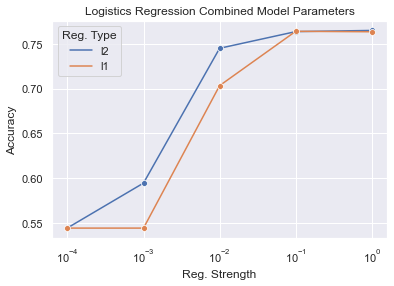

In [21]:
sb.set(rc={"figure.figsize":(8, 6)})
LR_Grid_plot = sb.lineplot(data=results_df, x='Reg. Strength', y='Accuracy', hue='Reg. Type', marker='o')
LR_Grid_plot.set(xscale='log',title = 'Logistics Regression Combined Model Parameters')
LR_Grid_plot.get_figure().savefig('../plots/LogisticRegression_Grid_plot.png', dpi=300, bbox_inches='tight')

Best model is:

$penalty = L1$

$C = 1$

Any of the penalty types would work and any C value between 0.1 and 1 would work also.

In [22]:
LR_model = LogisticRegression(max_iter=1000, random_state=14, tol=1.0e-08, 
                              penalty = 'l1', C = 1, solver='liblinear')

In [23]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', LR_model)])

In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'League'),
                                                                    ('Info',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'GameType'),
                                                                    ('Blue',
                                                                     'Top'),
                                                                    ('Blue',
                                                                     'TopChamp'),
                                                                    ('Blue',
                                                                     'Jungle'),
                                                                    ('Blue',
                                                                     'JungleChamp'),
                                                                    ('Blue',
                                                                     'Middle'),
                                                                    ('Blue',
                                                                     'MiddleChamp'),
                                                                    ('Blue',
                                                                     'A...
                                                                     'min_15'),
                                                                    ('goldblueMiddle',
                                                                     'min_20'),
                                                                    ('goldblueADC',
                                                                     'min_5'),
                                                                    ('goldblueADC',
                                                                     'min_10'),
                                                                    ('goldblueADC',
                                                                     'min_15'),
                                                                    ('goldblueADC',
                                                                     'min_20'),
                                                                    ('goldblueSupport',
                                                                     'min_5'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000002A03C454820>))])),
                ('model',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    random_state=14, solver='liblinear',
                                    tol=1e-08))])

In [25]:
LR_acc = util.print_accuracies(pipe, X_train, y_train, X_test, y_test)

Train accuracy 0.768	Test accuracy 0.784


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [26]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe, X_train, y_train, cv=skf)
LRscores = scores

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users

([], [])

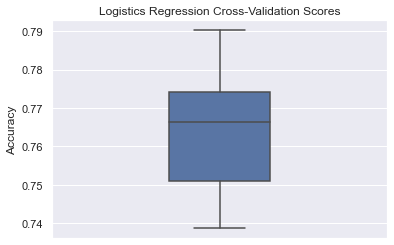

In [27]:
LR_plot = sb.boxplot(data=scores, width=0.3)

LR_plot.set(title = 'Logistics Regression Cross-Validation Scores', ylabel='Accuracy')
plt.xticks([], [])

#plt.show()

In [29]:
LR_acc_sel = util.print_accuracies(pipe, X_train, y_train, X_test, y_test)

Train accuracy 0.768	Test accuracy 0.784


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Feature Selection

In [30]:
pipe.named_steps['data'].get_feature_names_out()

array(['category__x12_Bang', 'category__x14_Wolf', 'category__x5_SKT',
       'category__x21_Faker', 'category__x23_Bang', 'category__x25_Wolf',
       'category__x16_SKT', 'category__x16_ahq', 'numeric__x39',
       'numeric__x40', 'numeric__x43', 'numeric__x44', 'numeric__x47',
       'numeric__x48', 'numeric__x76', 'numeric__x80', 'numeric__x89',
       'numeric__x90', 'numeric__x93', 'numeric__x94'], dtype=object)

In [31]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].coef_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Coef': list(feature_coefs.flatten())})
feature_df.sort_values(by='Coef', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df.head(20)

,Feature Name,Coef
0,numeric__x48,7.549000
1,numeric__x94,3.382792
2,numeric__x80,1.177883
3,category__x16_ahq,1.137728
4,numeric__x90,0.955682
5,numeric__x39,0.534531
6,category__x23_Bang,0.529595
7,numeric__x43,0.431031
8,category__x25_Wolf,0.361470
9,category__x16_SKT,0.001401


In [32]:
X_cols = pd.DataFrame(X.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X.columns)-1, num=len(X.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'League')",
 '1': "('Info', 'Year')",
 '2': "('Info', 'Season')",
 '3': "('Info', 'GameType')",
 '4': "('Info', 'gamelength')",
 '5': "('Blue', 'TeamTag')",
 '6': "('Blue', 'Top')",
 '7': "('Blue', 'TopChamp')",
 '8': "('Blue', 'Jungle')",
 '9': "('Blue', 'JungleChamp')",
 '10': "('Blue', 'Middle')",
 '11': "('Blue', 'MiddleChamp')",
 '12': "('Blue', 'ADC')",
 '13': "('Blue', 'ADCChamp')",
 '14': "('Blue', 'Support')",
 '15': "('Blue', 'SupportChamp')",
 '16': "('Red', 'TeamTag')",
 '17': "('Red', 'Top')",
 '18': "('Red', 'TopChamp')",
 '19': "('Red', 'Jungle')",
 '20': "('Red', 'JungleChamp')",
 '21': "('Red', 'Middle')",
 '22': "('Red', 'MiddleChamp')",
 '23': "('Red', 'ADC')",
 '24': "('Red', 'ADCChamp')",
 '25': "('Red', 'Support')",
 '26': "('Red', 'SupportChamp')",
 '27': "('Blue', 'ban_1')",
 '28': "('Blue', 'ban_2')",
 '29': "('Blue', 'ban_3')",
 '30': "('Blue', 'ban_4')",
 '31': "('Blue', 'ban_5')",
 '32': "('Red', 'ban_1')",
 '33': "('Red', 'ban_2')",
 '34': "

In [33]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Coef,Feature Name 2
0,numeric__x48,7.549000,goldred_min_20
1,numeric__x94,3.382792,Red_Kills
2,numeric__x80,1.177883,goldredMiddle_min_20
3,category__x16_ahq,1.137728,Red_TeamTag_ahq
4,numeric__x90,0.955682,Red_Towers
5,numeric__x39,0.534531,golddiff_min_15
6,category__x23_Bang,0.529595,Red_ADC_Bang
7,numeric__x43,0.431031,goldblue_min_15
8,category__x25_Wolf,0.361470,Red_Support_Wolf
9,category__x16_SKT,0.001401,Red_TeamTag_SKT


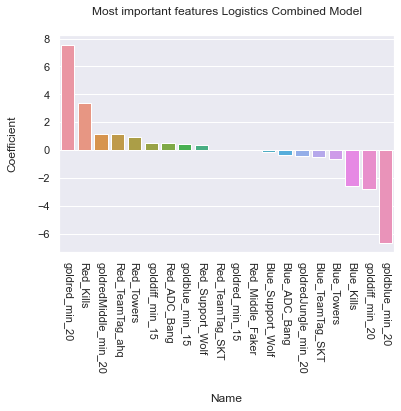

In [34]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Coef', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Name', rotation=0, labelpad=20)
ax.set_title('Most important features Logistics Combined Model', pad=20)
plt.savefig('../plots/LogisticRegression_coefs.png',dpi=300, bbox_inches = "tight")

It seems like the most important features are relating to the gold difference between the team. This is reasonable as gold has remained a constant variable across the different seasons.

# SVM

In [35]:
SGD_model = SGDClassifier(loss='log_loss', penalty='L2', max_iter=1000, random_state=20220905, tol=1.0e-03)

In [36]:
pipe2 = Pipeline(steps=[('encoder', columns), ('model', SGD_model)])

In [37]:
param_grid = {
    'model__penalty': ['l2', 'l1'],
    'model__alpha': np.logspace(-4, 0, 5)
}

grid_search = GridSearchCV(pipe2, param_grid=param_grid)

In [38]:
grid_search.fit(X_train, y_train)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all

GridSearchCV(estimator=Pipeline(steps=[('encoder',
                                        ColumnTransformer(transformers=[('category',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         [('Info',
                                                                           'League'),
                                                                          ('Info',
                                                                           'Year'),
                                                                          ('Info',
                                                                           'Season'),
                                                                          ('Info',
                                                                           'GameType'),
                                                                          ('Blue',
                                                                           'Top'),
                                                                          ('Blue',
                                                                           'TopChamp'),
                                                                          ('Blue',
                                                                           'Jungle'),
                                                                          ('Blue',
                                                                           'JungleChamp'),
                                                                          ('Blue',
                                                                           'Middle'),
                                                                          ('Blue',
                                                                           'MiddleChamp'),
                                                                          ('Blue',
                                                                           'ADC')...
                                                                           'min_15'),
                                                                          ('goldblueMiddle',
                                                                           'min_20'),
                                                                          ('goldblueADC',
                                                                           'min_5'),
                                                                          ('goldblueADC',
                                                                           'min_10'),
                                                                          ('goldblueADC',
                                                                           'min_15'),
                                                                          ('goldblueADC',
                                                                           'min_20'),
                                                                          ('goldblueSupport',
                                                                           'min_5'), ...])])),
                                       ('model',
                                        SGDClassifier(loss='log_loss',
                                                      penalty='L2',
                                                      random_state=20220905))]),
             param_grid={'model__alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'model__penalty': ['l2', 'l1']})

In [39]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

In [40]:
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [41]:
results_df = pd.DataFrame(rows)
results_df.columns = ['alpha', 'Reg. Type', 'Accuracy']
results_df

,alpha,Reg. Type,Accuracy
0,0.0001,l2,0.729464
1,0.0001,l1,0.718743
2,0.0010,l2,0.756355
3,0.0010,l1,0.763612
4,0.0100,l2,0.764766
5,0.0100,l1,0.754703
6,0.1000,l2,0.742499
7,0.1000,l1,0.544210
8,1.0000,l2,0.547510
9,1.0000,l1,0.526388


Plot the accuracy by regularization strengh for the different types of regularization.

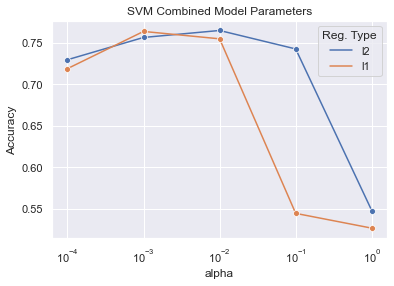

In [42]:
SGD_Grid_plot = sb.lineplot(data=results_df, x='alpha', y='Accuracy', hue='Reg. Type', marker='o')
SGD_Grid_plot.set(xscale='log', title = 'SVM Combined Model Parameters')

SGD_Grid_plot.get_figure().savefig('../plots/SVM_Grid_plot.png', dpi=300, bbox_inches='tight')

Best model is:

$penalty = L2$

$\alpha = 0.01$

In [43]:
SGD_model = SGDClassifier(loss='log_loss', penalty='L2', max_iter=1000,
                          random_state=20220905, tol=1.0e-03, alpha = 1e-2)

In [44]:
pipe2 = Pipeline(steps=[('data', data_pipe), ('model', SGD_model)])

In [45]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'League'),
                                                                    ('Info',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'GameType'),
                                                                    ('Blue',
                                                                     'Top'),
                                                                    ('Blue',
                                                                     'TopChamp'),
                                                                    ('Blue',
                                                                     'Jungle'),
                                                                    ('Blue',
                                                                     'JungleChamp'),
                                                                    ('Blue',
                                                                     'Middle'),
                                                                    ('Blue',
                                                                     'MiddleChamp'),
                                                                    ('Blue',
                                                                     'A...
                                                                    ('goldblueMiddle',
                                                                     'min_15'),
                                                                    ('goldblueMiddle',
                                                                     'min_20'),
                                                                    ('goldblueADC',
                                                                     'min_5'),
                                                                    ('goldblueADC',
                                                                     'min_10'),
                                                                    ('goldblueADC',
                                                                     'min_15'),
                                                                    ('goldblueADC',
                                                                     'min_20'),
                                                                    ('goldblueSupport',
                                                                     'min_5'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000002A03C454820>))])),
                ('model',
                 SGDClassifier(alpha=0.01, loss='log_loss', penalty='L2',
                               random_state=20220905))])

In [46]:
SGD_acc =util.print_accuracies(pipe2, X_train, y_train, X_test, y_test)

Train accuracy 0.760	Test accuracy 0.776


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [47]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe2, X_train, y_train, cv=skf)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users

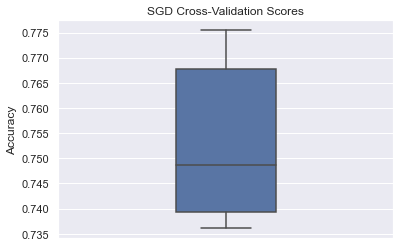

In [48]:
SGDscores = scores
SGD_plot = sb.boxplot(data=scores, width=0.3)

SGD_plot.set(title = 'SGD Cross-Validation Scores', ylabel ='Accuracy')
plt.xticks([], [])

plt.show()

In [50]:
SGD_acc_sel =util.print_accuracies(pipe2, X_train, y_train, X_test, y_test)

Train accuracy 0.760	Test accuracy 0.776


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Feature Selection

In [51]:
pipe2.named_steps['data'].get_feature_names_out()

array(['category__x12_Bang', 'category__x14_Wolf', 'category__x5_SKT',
       'category__x21_Faker', 'category__x23_Bang', 'category__x25_Wolf',
       'category__x16_SKT', 'category__x16_ahq', 'numeric__x39',
       'numeric__x40', 'numeric__x43', 'numeric__x44', 'numeric__x47',
       'numeric__x48', 'numeric__x76', 'numeric__x80', 'numeric__x89',
       'numeric__x90', 'numeric__x93', 'numeric__x94'], dtype=object)

In [52]:
feature_names = pipe2.named_steps['data'].get_feature_names_out()
feature_coefs = pipe2.named_steps['model'].coef_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Coef': list(feature_coefs.flatten())})
feature_df.sort_values(by='Coef', axis=0, ascending=False, inplace=True, ignore_index=True)
#feature_df['feature'].replace(to_replace=['numeric__','category__','ABBREVIATION_'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Coef
0,numeric__x48,0.986609
1,numeric__x90,0.977057
2,numeric__x80,0.893089
3,numeric__x47,0.780131
4,numeric__x76,0.743960
5,numeric__x94,0.674318
6,category__x16_ahq,0.230035
7,category__x23_Bang,0.156627
8,category__x16_SKT,0.156627
9,category__x25_Wolf,0.154167


In [53]:
X_cols = pd.DataFrame(X.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X.columns)-1, num=len(X.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'League')",
 '1': "('Info', 'Year')",
 '2': "('Info', 'Season')",
 '3': "('Info', 'GameType')",
 '4': "('Info', 'gamelength')",
 '5': "('Blue', 'TeamTag')",
 '6': "('Blue', 'Top')",
 '7': "('Blue', 'TopChamp')",
 '8': "('Blue', 'Jungle')",
 '9': "('Blue', 'JungleChamp')",
 '10': "('Blue', 'Middle')",
 '11': "('Blue', 'MiddleChamp')",
 '12': "('Blue', 'ADC')",
 '13': "('Blue', 'ADCChamp')",
 '14': "('Blue', 'Support')",
 '15': "('Blue', 'SupportChamp')",
 '16': "('Red', 'TeamTag')",
 '17': "('Red', 'Top')",
 '18': "('Red', 'TopChamp')",
 '19': "('Red', 'Jungle')",
 '20': "('Red', 'JungleChamp')",
 '21': "('Red', 'Middle')",
 '22': "('Red', 'MiddleChamp')",
 '23': "('Red', 'ADC')",
 '24': "('Red', 'ADCChamp')",
 '25': "('Red', 'Support')",
 '26': "('Red', 'SupportChamp')",
 '27': "('Blue', 'ban_1')",
 '28': "('Blue', 'ban_2')",
 '29': "('Blue', 'ban_3')",
 '30': "('Blue', 'ban_4')",
 '31': "('Blue', 'ban_5')",
 '32': "('Red', 'ban_1')",
 '33': "('Red', 'ban_2')",
 '34': "

In [54]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Coef,Feature Name 2
0,numeric__x48,0.986609,goldred_min_20
1,numeric__x90,0.977057,Red_Towers
2,numeric__x80,0.893089,goldredMiddle_min_20
3,numeric__x47,0.780131,goldred_min_15
4,numeric__x76,0.743960,goldredJungle_min_20
5,numeric__x94,0.674318,Red_Kills
6,category__x16_ahq,0.230035,Red_TeamTag_ahq
7,category__x23_Bang,0.156627,Red_ADC_Bang
8,category__x16_SKT,0.156627,Red_TeamTag_SKT
9,category__x25_Wolf,0.154167,Red_Support_Wolf


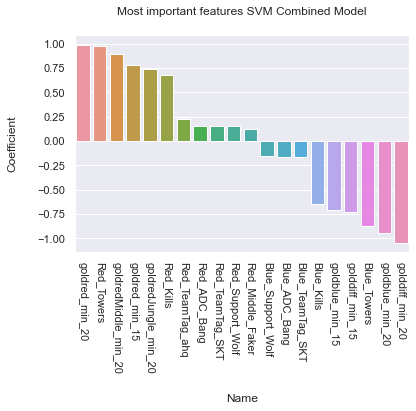

In [55]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Coef', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Name', rotation=0, labelpad=20)
ax.set_title('Most important features SVM Combined Model', pad=20)
plt.savefig('../plots/SVM_coefs.png',dpi=300, bbox_inches = "tight")

Just like the Logistics Regression model, the gold difference is the most important factor.

# Generalizing the model to predict outcome with just a singel team's stats, instead using team vs team data.

The general idea is here is to see how accurate the model is looking at the stats of one team instead of team vs team like above. The trade off here is that there is more data for the models to learn from, but some context is lost to the model. We now have each team on a seperate row and a column to indicate which team we are looking at.

In [56]:
blue = df['Blue'].copy()
blue['Team'] = 'Blue'

red = df['Red'].copy()
red['Team'] = 'Red'

info = df['Info'].copy()

Code below is for seperating the features with the same name across the teams. For example, ADC gold is a feature twice once for blue team and once for red team.

In [57]:
diff = df['golddiff'].copy()
diff.columns = ['Diff 5','Diff 10','Diff 15','Diff 20']
info = pd.concat([info,diff], axis=1)

gold = df['goldred'].copy()
gold.columns = ['Team 5','Team 10','Team 15','Team 20']
red = pd.concat([red,gold], axis=1)

gold = df['goldblue'].copy()
gold.columns = ['Team 5','Team 10','Team 15','Team 20']
blue = pd.concat([blue,gold], axis=1)

In [58]:
goldcol = ['goldblueTop','goldblueJungle','goldblueADC','goldblueSupport','goldblueMiddle',
          'goldredTop','goldredJungle','goldredADC','goldredSupport','goldredMiddle']

for i in goldcol:
    gold = df[i]
    if i[4:7] == 'red':
        gold.columns = [i[7:]+' 5',i[7:]+' 10',i[7:]+' 15',i[7:]+' 20']
        red = pd.concat([red,gold], axis=1)
    elif i[4:8] == 'blue':
        gold.columns = [i[8:]+' 5',i[8:]+' 10',i[8:]+' 15',i[8:]+' 20']
        blue = pd.concat([blue,gold], axis=1)

In [59]:
blue = pd.concat([info,blue], axis=1)
red = pd.concat([info,red], axis=1)

df2 = pd.concat([blue,red],axis=0)

In [60]:
y = df2['Winner']
X = df2.drop(['Winner','Address'],axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20220905, stratify=y)

# Logistics Regression 2

Creating the model and the pipeline to search for the optimal parameters

In [63]:
LR_model = LogisticRegression(penalty='none', max_iter=1000, random_state=14, tol=1.0e-08, solver='liblinear')

In [64]:
CATEGORICAL_VARS=['League', 'Season', 'GameType', 'TeamTag', 'Top', 'TopChamp', 'Jungle',
                  'JungleChamp', 'Middle', 'MiddleChamp',
                   'ADC', 'ADCChamp', 'Support', 'SupportChamp', 'ban_1', 'ban_2', 'ban_3',
                   'ban_4', 'ban_5', 'Team']

NUMERIC_VARS=['gamelength','Year',
              'Towers', 'Inhib', 'Kills', 'Team 5',
       'Team 10', 'Team 15', 'Team 20', 'Top 5', 'Top 10', 'Top 15', 'Top 20',
       'Jungle 5', 'Jungle 10', 'Jungle 15', 'Jungle 20', 'ADC 5', 'ADC 10',
       'ADC 15', 'ADC 20', 'Support 5', 'Support 10', 'Support 15',
       'Support 20', 'Middle 5', 'Middle 10', 'Middle 15', 'Middle 20']

columns=ColumnTransformer([('category',OneHotEncoder(drop='first',handle_unknown='ignore'),CATEGORICAL_VARS),
                           ('numeric',MinMaxScaler(),NUMERIC_VARS)], remainder='drop')

In [65]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [66]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', LR_model)])

Grid Search and plot of the accuracies to examine best parameters to set the model as.

In [67]:
param_grid = {
    'model__penalty': ['l2', 'l1'],
    'model__C': np.logspace(-4, 0, 5)
    
}

grid_search = GridSearchCV(pipe, param_grid=param_grid)

In [68]:
grid_search.fit(X_train, y_train)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18] during t

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18] during t

GridSearchCV(estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          ['League',
                                                                                           'Season',
                                                                                           'GameType',
                                                                                           'TeamTag',
                                                                                           'Top',
                                                                                           'TopChamp',
                                                                                           'Jungle',
                                                                                           'JungleChamp',
                                                                                           'Middle',
                                                                                           'MiddleChamp',
                                                                                           'ADC',
                                                                                           'ADCChamp',
                                                                                           'Support',
                                                                                           'SupportChamp',
                                                                                           'ban_1',
                                                                                           'ban_2',
                                                                                           'ban_3',
                                                                                           'ban_4',...
                                                                                           'Support '
                                                                                           '20',
                                                                                           'Middle '
                                                                                           '5',
                                                                                           'Middle '
                                                                                           '10',
                                                                                           'Middle '
                                                                                           '15',
                                                                                           'Middle '
                                                                                           '20'])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x000002A03C454820>))])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='none',
                                                           random_state=14,
                                                           solver='liblinear',
                                                           tol=1e-08))]),
        

In [69]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

In [70]:
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [71]:
rows

[{'model__C': 0.0001, 'model__penalty': 'l2', 'score': 0.5442098261372529},
 {'model__C': 0.0001, 'model__penalty': 'l1', 'score': 0.5442098261372529},
 {'model__C': 0.001, 'model__penalty': 'l2', 'score': 0.5442098261372529},
 {'model__C': 0.001, 'model__penalty': 'l1', 'score': 0.5442098261372529},
 {'model__C': 0.01, 'model__penalty': 'l2', 'score': 0.543715082848491},
 {'model__C': 0.01, 'model__penalty': 'l1', 'score': 0.5442098261372529},
 {'model__C': 0.1, 'model__penalty': 'l2', 'score': 0.5391790003742643},
 {'model__C': 0.1, 'model__penalty': 'l1', 'score': 0.5421479364431289},
 {'model__C': 1.0, 'model__penalty': 'l2', 'score': 0.5395088972814808},
 {'model__C': 1.0, 'model__penalty': 'l1', 'score': 0.5395088972814808}]

In [72]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Reg. Strength', 'Reg. Type', 'Accuracy']
results_df

,Reg. Strength,Reg. Type,Accuracy
0,0.0001,l2,0.544210
1,0.0001,l1,0.544210
2,0.0010,l2,0.544210
3,0.0010,l1,0.544210
4,0.0100,l2,0.543715
5,0.0100,l1,0.544210
6,0.1000,l2,0.539179
7,0.1000,l1,0.542148
8,1.0000,l2,0.539509
9,1.0000,l1,0.539509


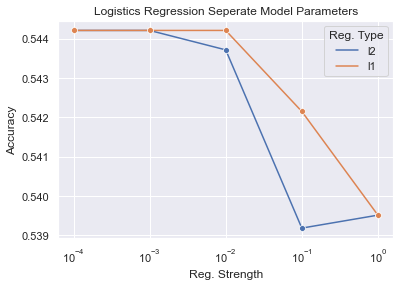

In [73]:
LR_Grid_plot = sb.lineplot(data=results_df, x='Reg. Strength', y='Accuracy', hue='Reg. Type', marker='o')
LR_Grid_plot.set(xscale='log', title = 'Logistics Regression Seperate Model Parameters')

LR_Grid_plot.get_figure().savefig('../plots/Logistics_Regression_Model2_Grid_plot.png', dpi=300, bbox_inches='tight')

Best model is:

$penalty = L1$

$C = 0.01$

In [74]:
LR_model = LogisticRegression( max_iter=1000, random_state=14,
                              tol=1.0e-08, penalty = 'l2', C = 1e-4 , solver='liblinear')

In [75]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', LR_model)])

In [76]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['League',
                                                                    'Season',
                                                                    'GameType',
                                                                    'TeamTag',
                                                                    'Top',
                                                                    'TopChamp',
                                                                    'Jungle',
                                                                    'JungleChamp',
                                                                    'Middle',
                                                                    'MiddleChamp',
                                                                    'ADC',
                                                                    'ADCChamp',
                                                                    'Support',
                                                                    'SupportChamp',
                                                                    'ban_1',
                                                                    'ban_2',
                                                                    'ban_3',
                                                                    'ban_4',
                                                                    'ban_5',
                                                                    'Team']),
                                                                  ('nume...
                                                                    'Jungle 5',
                                                                    'Jungle 10',
                                                                    'Jungle 15',
                                                                    'Jungle 20',
                                                                    'ADC 5',
                                                                    'ADC 10',
                                                                    'ADC 15',
                                                                    'ADC 20',
                                                                    'Support 5',
                                                                    'Support '
                                                                    '10',
                                                                    'Support '
                                                                    '15',
                                                                    'Support '
                                                                    '20',
                                                                    'Middle 5',
                                                                    'Middle 10',
                                                                    'Middle 15',
                                                                    'Middle '
                                                                    '20'])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000002A03C454820>))])),
                ('model',
                 LogisticRegression(C=0.0001, max_iter=1000, random_state=14,
                                    solver='liblinear', tol=1e-08))])

In [77]:
LR2_acc =util.print_accuracies(pipe, X_train, y_train, X_test, y_test)

Train accuracy 0.544	Test accuracy 0.544


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [78]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe, X_train, y_train, cv=skf)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown c

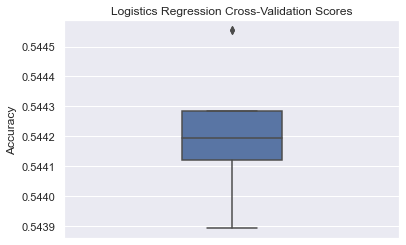

In [79]:
LR2scores = scores
LR_plot = sb.boxplot(data=scores, width=0.3)

LR_plot.set_title('Logistics Regression Cross-Validation Scores')
LR_plot.set_ylabel('Accuracy')
plt.xticks([], [])

plt.show()

Feature Selection

In [80]:
pipe.named_steps['data'].get_feature_names_out()

array(['category__TeamTag_GV', 'category__Top_Atyamomo',
       'category__Top_Rest', 'category__Middle_Jiizuke',
       'category__MiddleChamp_Talon', 'category__ADC_Minitroupax',
       'category__ADC_Neverloses', 'category__ADC_aMiracle',
       'category__Support_Bunny FuFuu', 'category__Support_Jactroll',
       'category__ban_1_Thresh', 'category__ban_1_TwistedFate',
       'category__ban_1_Varus', 'category__ban_2_Lissandra',
       'category__ban_3_Jayce', 'category__ban_3_Urgot',
       'category__ban_4_Karma', 'category__ban_4_Sion',
       'category__ban_5_Bard', 'category__ban_5_Cassiopeia'], dtype=object)

In [81]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].coef_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Coef': list(feature_coefs.flatten())})
feature_df.sort_values(by='Coef', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df['Feature Name'].replace(to_replace=['numeric__','category__'], value='', regex=True, inplace=True)
#feature_df['feature'].replace(to_replace=['numeric__','category__','ABBREVIATION_'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Coef
0,ban_1_Thresh,0.001407
1,ban_2_Lissandra,0.001225
2,Support_Bunny FuFuu,0.001112
3,ban_1_TwistedFate,0.000975
4,ban_5_Bard,0.000781
5,TeamTag_GV,0.000692
6,Top_Atyamomo,0.000626
7,ADC_Minitroupax,0.000412
8,Support_Jactroll,0.000412
9,Middle_Jiizuke,0.000412


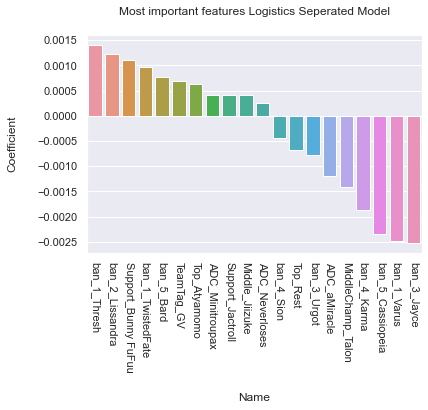

In [82]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name', y='Coef', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Name', rotation=0, labelpad=20)
ax.set_title('Most important features Logistics Seperated Model', pad=20)
plt.savefig('../plots/LR2_coefs.png',dpi=300, bbox_inches = "tight")

Taking out the gold difference since to have a major change on the feature importance. It looks like who is ban is the most important feature now.

# SVM

In [83]:
SGD_model = SGDClassifier(loss='log_loss', penalty='L2', max_iter=1000, random_state=20220905, tol=1.0e-03)

In [84]:
pipe2 = Pipeline(steps=[('data', data_pipe), ('model', SGD_model)])

In [85]:
param_grid = {
    'model__penalty': ['l2', 'l1'],
    'model__alpha': np.logspace(-4, 0, 5)
}

grid_search = GridSearchCV(pipe2, param_grid=param_grid)

In [86]:
grid_search.fit(X_train, y_train)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18] during t

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17, 18] during t

GridSearchCV(estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          ['League',
                                                                                           'Season',
                                                                                           'GameType',
                                                                                           'TeamTag',
                                                                                           'Top',
                                                                                           'TopChamp',
                                                                                           'Jungle',
                                                                                           'JungleChamp',
                                                                                           'Middle',
                                                                                           'MiddleChamp',
                                                                                           'ADC',
                                                                                           'ADCChamp',
                                                                                           'Support',
                                                                                           'SupportChamp',
                                                                                           'ban_1',
                                                                                           'ban_2',
                                                                                           'ban_3',
                                                                                           'ban_4',...
                                                                                           'Support '
                                                                                           '10',
                                                                                           'Support '
                                                                                           '15',
                                                                                           'Support '
                                                                                           '20',
                                                                                           'Middle '
                                                                                           '5',
                                                                                           'Middle '
                                                                                           '10',
                                                                                           'Middle '
                                                                                           '15',
                                                                                           'Middle '
                                                                                           '20'])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x000002A03C454820>))])),
                                     

In [87]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']

In [88]:
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [89]:
results_df = pd.DataFrame(rows)
results_df.columns = ['alpha', 'Reg. Type', 'Accuracy']
results_df

,alpha,Reg. Type,Accuracy
0,0.0001,l2,0.538932
1,0.0001,l1,0.538189
2,0.0010,l2,0.538107
3,0.0010,l1,0.541653
4,0.0100,l2,0.543798
5,0.0100,l1,0.544210
6,0.1000,l2,0.542065
7,0.1000,l1,0.544210
8,1.0000,l2,0.472202
9,1.0000,l1,0.473522


Plot the accuracy by regularization strengh for the different types of regularization.

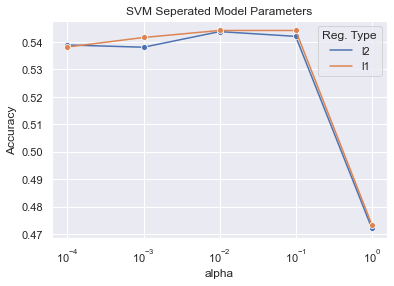

In [90]:
SGD_Grid_plot = sb.lineplot(data=results_df, x='alpha', y='Accuracy', hue='Reg. Type', marker='o')
SGD_Grid_plot.set(xscale='log', title = 'SVM Seperated Model Parameters')

SGD_Grid_plot.get_figure().savefig('../plots/SVM2_Grid_plot.png', dpi=300, bbox_inches='tight')

Best model is:

$penalty = L2$

$\alpha = 0.01$

In [91]:
SGD_model = SGDClassifier(loss='log_loss', penalty='L2', max_iter=1000,
                          random_state=20220905, tol=1.0e-02, alpha = 1e-4)

In [92]:
pipe2 = Pipeline(steps=[('data', data_pipe), ('model', SGD_model)])

In [93]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['League',
                                                                    'Season',
                                                                    'GameType',
                                                                    'TeamTag',
                                                                    'Top',
                                                                    'TopChamp',
                                                                    'Jungle',
                                                                    'JungleChamp',
                                                                    'Middle',
                                                                    'MiddleChamp',
                                                                    'ADC',
                                                                    'ADCChamp',
                                                                    'Support',
                                                                    'SupportChamp',
                                                                    'ban_1',
                                                                    'ban_2',
                                                                    'ban_3',
                                                                    'ban_4',
                                                                    'ban_5',
                                                                    'Team']),
                                                                  ('nume...
                                                                    'Top 15',
                                                                    'Top 20',
                                                                    'Jungle 5',
                                                                    'Jungle 10',
                                                                    'Jungle 15',
                                                                    'Jungle 20',
                                                                    'ADC 5',
                                                                    'ADC 10',
                                                                    'ADC 15',
                                                                    'ADC 20',
                                                                    'Support 5',
                                                                    'Support '
                                                                    '10',
                                                                    'Support '
                                                                    '15',
                                                                    'Support '
                                                                    '20',
                                                                    'Middle 5',
                                                                    'Middle 10',
                                                                    'Middle 15',
                                                                    'Middle '
                                                                    '20'])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000002A03C454820>))])),
                ('model',
                 SGDClassifier(loss='log_loss

In [94]:
SGD2_acc = util.print_accuracies(pipe2, X_train, y_train, X_test, y_test)

Train accuracy 0.552	Test accuracy 0.538


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [95]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe2, X_train, y_train, cv=skf)

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 8, 9, 12, 13, 16, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18] during transform. These unknown c

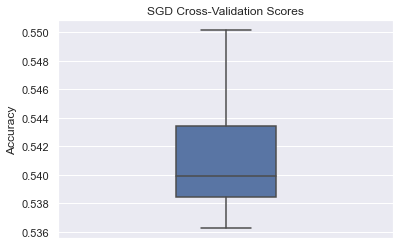

In [96]:
SGD2scores = scores
SGD_plot = sb.boxplot(data=scores, width=0.3)

SGD_plot.set_title('SGD Cross-Validation Scores')
SGD_plot.set_ylabel('Accuracy')
plt.xticks([], [])

plt.show()

Feature Selection

In [97]:
pipe.named_steps['data'].get_feature_names_out()

array(['category__TeamTag_GV', 'category__Top_Atyamomo',
       'category__Top_Rest', 'category__Middle_Jiizuke',
       'category__MiddleChamp_Talon', 'category__ADC_Minitroupax',
       'category__ADC_Neverloses', 'category__ADC_aMiracle',
       'category__Support_Bunny FuFuu', 'category__Support_Jactroll',
       'category__ban_1_Thresh', 'category__ban_1_TwistedFate',
       'category__ban_1_Varus', 'category__ban_2_Lissandra',
       'category__ban_3_Jayce', 'category__ban_3_Urgot',
       'category__ban_4_Karma', 'category__ban_4_Sion',
       'category__ban_5_Bard', 'category__ban_5_Cassiopeia'], dtype=object)

In [98]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].coef_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Coef': list(feature_coefs.flatten())})
feature_df.sort_values(by='Coef', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df['Feature Name'].replace(to_replace=['numeric__','category__'], value='', regex=True, inplace=True)
#feature_df['feature'].replace(to_replace=['numeric__','category__','ABBREVIATION_'], value='', regex=True, inplace=True)
feature_df.head(20)

,Feature Name,Coef
0,ban_1_Thresh,0.001407
1,ban_2_Lissandra,0.001225
2,Support_Bunny FuFuu,0.001112
3,ban_1_TwistedFate,0.000975
4,ban_5_Bard,0.000781
5,TeamTag_GV,0.000692
6,Top_Atyamomo,0.000626
7,ADC_Minitroupax,0.000412
8,Support_Jactroll,0.000412
9,Middle_Jiizuke,0.000412


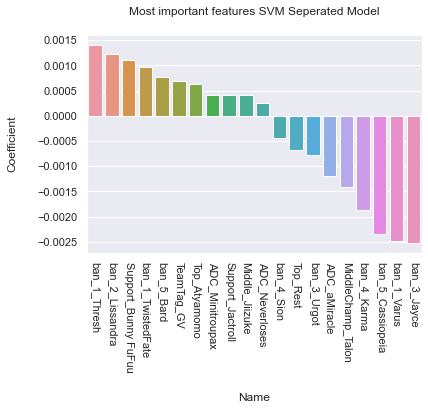

In [99]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name', y='Coef', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Name', rotation=0, labelpad=20)
ax.set_title('Most important features SVM Seperated Model', pad=20)
plt.savefig('../plots/SVM2_coefs.png',dpi=300, bbox_inches = "tight")

Like above, again the bans are important after taking out the gold diff.

# Accuracies comparison

In [100]:
acc_df = pd.DataFrame([LR_acc[0],SGD_acc[0],LR2_acc[0],SGD2_acc[0],
                       LR_acc[1],SGD_acc[1],LR2_acc[1],SGD2_acc[1]],
                      columns = ['Accuracy'])
acc_df['Type'] = ['Train','Train','Train','Train',
                  'Test','Test','Test','Test']
acc_df['Model'] = ['LR Com','SVM Com','LR Sep','SVM Sep',
                   'LR Com','SVM Com','LR Sep','SVM Sep']

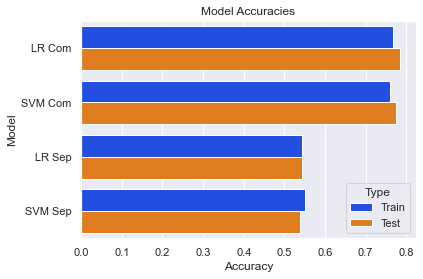

In [101]:
barplot = sb.barplot(data = acc_df, y = 'Model', x = 'Accuracy', hue = 'Type', palette = 'bright')
barplot.set(title = 'Model Accuracies')

barplot.get_figure().savefig('../plots/Logistics_barplot.png',dpi=300, bbox_inches='tight')

Box plot to see the range of of the scores from the cross validation.

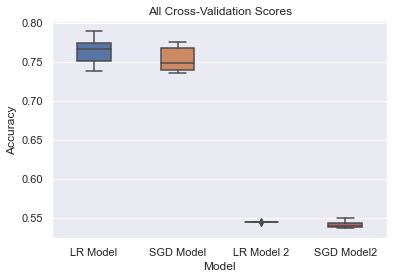

In [104]:
allbox = sb.boxplot(data = [LRscores,SGDscores,LR2scores,SGD2scores], width=0.4)
allbox.set(title ='All Cross-Validation Scores', ylabel = 'Accuracy', xlabel = 'Model')
allbox.set_xticklabels(['LR Model','SGD Model','LR Model 2','SGD Model2'])
allbox.get_figure().savefig('../plots/allboxplot.png', dpi=300, bbox_inches='tight')

Gold difference seems to have a major affect on the accuracy of the models. It's good to know that the gold difference is very important feature, but it's so big that it overshadows the other features. Which makes it harder to see what else is important.